In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time


In [2]:
df_data = pd.read_pickle(f"/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_data_1462_10650.pkl")
df_data


,Eddy_idx,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,xc,yc,w,Q11,Q12,Q22,Rc,psi0
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,830.505283,1516.358103,0.000017,0.002904,-0.000396,0.005650,24.781075,-36.259933
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.830407,1407.502025,0.000031,0.009018,-0.002230,0.006642,49.001445,-48.187084
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,928.354369,1356.372262,-0.000011,-0.001907,0.001393,-0.003376,73.000954,169.571400
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,753.364302,1284.532290,0.000022,0.006509,-0.001848,0.004420,64.751400,-23.291117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412607,24,10650,AE,151.460338,-38.218269,349.0,158.0,349,158,350.853554,156.210164,0.000033,0.010661,0.001276,0.005981,38.006653,-17.427862
412608,25,10650,CE,158.194230,-40.416548,973.0,126.0,973,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412609,26,10650,AE,156.242892,-40.165033,805.0,95.0,805,95,804.758015,95.239729,0.000011,0.003095,0.001063,0.002337,44.750654,-15.333051
412610,27,10650,CE,148.933514,-38.691752,157.0,34.0,157,34,156.085619,33.914840,-0.000007,-0.001505,-0.000893,-0.002159,47.500161,14.741252


In [3]:
df_data = df_data.dropna() # If DOPIOE didnt work then we dont have vorticity, which is required for tracking
start_day = df_data.Day.min()
end_day = df_data.Day.max()
# df_data = df_data[(df_data['Day']>=start_day)&(df_data['Day']<=end_day)]
df_data


,Eddy_idx,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,xc,yc,w,Q11,Q12,Q22,Rc,psi0
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,830.505283,1516.358103,0.000017,0.002904,-0.000396,0.005650,24.781075,-36.259933
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.830407,1407.502025,0.000031,0.009018,-0.002230,0.006642,49.001445,-48.187084
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,928.354369,1356.372262,-0.000011,-0.001907,0.001393,-0.003376,73.000954,169.571400
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,753.364302,1284.532290,0.000022,0.006509,-0.001848,0.004420,64.751400,-23.291117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412605,22,10650,AE,157.993708,-38.734350,912.0,300.0,912,300,911.755090,299.627733,0.000009,0.003026,-0.000616,0.001248,39.001497,-10.352792
412606,23,10650,CE,157.092189,-39.604423,860.0,180.0,860,180,860.284107,180.170175,-0.000008,-0.000905,-0.000273,-0.002966,59.000500,10.728906
412607,24,10650,AE,151.460338,-38.218269,349.0,158.0,349,158,350.853554,156.210164,0.000033,0.010661,0.001276,0.005981,38.006653,-17.427862
412609,26,10650,AE,156.242892,-40.165033,805.0,95.0,805,95,804.758015,95.239729,0.000011,0.003095,0.001063,0.002337,44.750654,-15.333051


In [4]:
start_ID = np.arange(len(df_data[df_data.Day==df_data.Day.min()]))
next_num = np.max(start_ID) + 1


In [5]:
def tracking(df_data, start_ID, next_num, VORT_WEIGHT=1e14, R_THRESH=60):

    tic = time.perf_counter()
    df_data = df_data.copy()
    min_day = df_data['Day'].min()
    df_data['Eddy'] = -1
    df_data.loc[df_data['Day'] == min_day, 'Eddy'] = start_ID
    df_data['Eddy'] = df_data['Eddy'].astype('Int64')

    unique_days = sorted(df_data['Day'].unique())
    day_dict = {
        d: df_data.index[(df_data['Day'] == d) & (~df_data['xc'].isna())]
        for d in unique_days
    }

    df_R_rows = []
    max_day = df_data['Day'].max()

    for day in range(min_day + 1, max_day + 1):
        if day not in day_dict or len(day_dict[day]) == 0:
            continue

        pres_day = df_data.loc[day_dict[day]].copy()
        unique_eddies = pres_day['Eddy_idx'].unique()
        assigned_IDs = set()  ### MODIFIED ### track assigned IDs per day

        for e_pres in unique_eddies:
            pres_eddy = pres_day[pres_day['Eddy_idx'] == e_pres].iloc[0]
            best_match = None
            best_R = np.inf

            for delta in range(1, 5): # Looks back 4 days max
                candidate_day = day - delta
                if candidate_day < min_day:
                    continue
                if candidate_day not in day_dict or len(day_dict[candidate_day]) == 0:
                    continue

                candidate_prev = df_data.loc[day_dict[candidate_day]]
                candidate_group = candidate_prev.groupby('Eddy_idx', as_index=False, sort=False).first()

                for _, prev_eddy in candidate_group.iterrows():
                    dx = pres_eddy['xc'] - prev_eddy['xc']
                    dy = pres_eddy['yc'] - prev_eddy['yc']
                    dw = pres_eddy['w'] - prev_eddy['w']
                    R = np.sqrt(dx ** 2 + dy ** 2 + VORT_WEIGHT * (dw ** 2))
                    
                    # D_diff = np.hypot(dx, dy)
                    # W_diff = np.abs(dw)
                    # df_R_rows.append({'D_diff': D_diff, 'W_diff': W_diff, 'R': R})

                    # Check match criteria
                    if (
                        R < R_THRESH
                        and pres_eddy['Cyc'] == prev_eddy['Cyc']
                        and prev_eddy['Eddy'] not in assigned_IDs  ### MODIFIED ###
                        and not pd.isna(prev_eddy['Eddy'])
                    ):
                        if R < best_R:
                            best_match = prev_eddy
                            best_R = R

            if best_match is not None:
                matched_id = best_match['Eddy']
                df_data.loc[(df_data['Day'] == day) & (df_data['Eddy_idx'] == e_pres), 'Eddy'] = matched_id
                assigned_IDs.add(matched_id)  ### MODIFIED ###
            else:
                df_data.loc[(df_data['Day'] == day) & (df_data['Eddy_idx'] == e_pres), 'Eddy'] = next_num
                assigned_IDs.add(next_num)  ### MODIFIED ###
                next_num += 1

        if day % 200 == 0:
            toc = time.perf_counter()
            print(f"Elapsed time: {toc - tic:.4f} seconds")
            print(day)

    df_R = pd.DataFrame(df_R_rows)
    df_data['next_num'] = next_num

    # Final check for duplicates
    assert not df_data.duplicated(subset=['Eddy', 'Day']).any(), "Duplicate (Eddy, Day) pairs found!"

    return df_data, df_R


In [6]:
df_eddies, df_R = tracking(df_data, start_ID, next_num)
df_eddies.to_pickle(f"/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_{start_day}_{end_day}.pkl")


Elapsed time: 61.2430 seconds
1600
Elapsed time: 204.9816 seconds
1800
Elapsed time: 295.0210 seconds
2000
Elapsed time: 402.4630 seconds
2200
Elapsed time: 485.2382 seconds
2400
Elapsed time: 584.1930 seconds
2600
Elapsed time: 690.9561 seconds
2800
Elapsed time: 785.1558 seconds
3000
Elapsed time: 881.3039 seconds
3200
Elapsed time: 955.4744 seconds
3400
Elapsed time: 1066.5479 seconds
3600
Elapsed time: 1151.4563 seconds
3800
Elapsed time: 1279.0626 seconds
4000
Elapsed time: 1371.3526 seconds
4200
Elapsed time: 1487.8372 seconds
4400
Elapsed time: 1581.8822 seconds
4600
Elapsed time: 1697.9331 seconds
4800
Elapsed time: 1819.4198 seconds
5000
Elapsed time: 1928.8527 seconds
5200
Elapsed time: 2054.9396 seconds
5400
Elapsed time: 2147.2288 seconds
5600
Elapsed time: 2278.9021 seconds
5800
Elapsed time: 2364.3372 seconds
6000
Elapsed time: 2522.5707 seconds
6200
Elapsed time: 2624.0167 seconds
6400
Elapsed time: 2750.7081 seconds
6600
Elapsed time: 2883.4618 seconds
6800
Elapsed time

In [7]:
# plt.figure(figsize=(15,4))
# plt.hist(df_R.R, bins=10000)
# plt.axvline(x=60, color='r')
# plt.xlabel('R', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.xlim(-10, 1750)


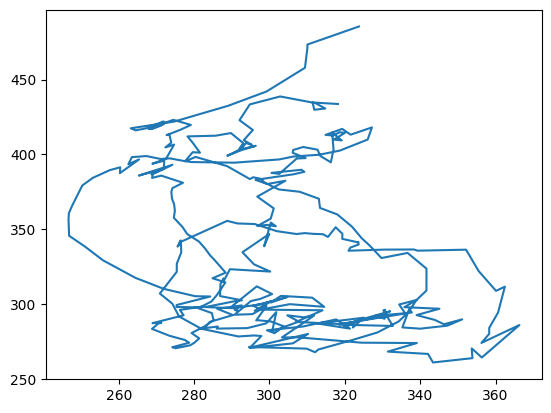

In [13]:
df = df_eddies[df_eddies.Eddy==df_eddies.Eddy.mode()[0]]

plt.plot(df.xc, df.yc)
plt.plot(df.xc, df.yc)

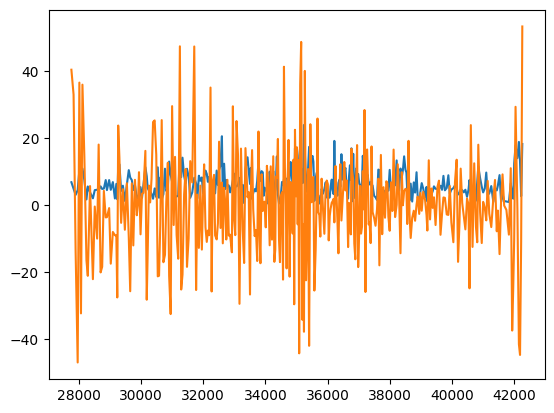

In [11]:
W = df.w.diff()
D = np.hypot(df.xc.diff(), df.yc.diff())
plt.plot(D)
VORT_WEIGHT=1e7
plt.plot(W*VORT_WEIGHT)
